We import the dataset from github

In [ ]:
!git clone https://github.com/Juru-Systems/Maize_Dataset.git

Cloning into 'Maize_Dataset'...
remote: Enumerating objects: 4923, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 4923 (delta 42), reused 68 (delta 41), pack-reused 4854
Receiving objects: 100% (4923/4923), 162.57 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [ ]:
from Maize_Dataset import maize_dataset

In [ ]:
b = maize_dataset.compile(class_encoding='class', ratio=[.7,.2,.1], equal_ratio_to_healthy=False)  

In [ ]:
b.visualise_tree

train folder
    |--class blight
          |--contains 802 Original images
          |--contains 4812 Generic images
    |--class common_rust
          |--contains 914 Original images
          |--contains 5484 Generic images
    |--class gray_leaf_spot
          |--contains 401 Original images
          |--contains 2406 Generic images
    |--class healthy
          |--contains 813 Original images
          |--contains 4878 Generic images
val folder
    |--class blight
          |--contains 229 Original images
          |--contains 0 Generic images
    |--class common_rust
          |--contains 261 Original images
          |--contains 0 Generic images
    |--class gray_leaf_spot
          |--contains 114 Original images
          |--contains 0 Generic images
    |--class healthy
          |--contains 232 Original images
          |--contains 0 Generic images
test folder
    |--class blight
          |--contains 115 Original images
          |--contains 0 Generic images
    |--class co

In [ ]:
import numpy as np
import tensorflow as tf
from Maize_Dataset import maize_dataset
from matplotlib import pyplot as plt
import cv2
from shutil import move
import os
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from keras.optimizer_v2 import adam as adam_v2
import json

In [ ]:

train_data_generator =  ImageDataGenerator(rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

val_data_generator =  ImageDataGenerator(rescale=1./255,)

In [ ]:
train_dataset = train_data_generator.flow_from_directory(
                                    "Maize_Dataset/temp/train/",
                                    target_size = (224, 224),
                                    class_mode = "categorical",
                                    batch_size = 32,)

Found 20510 images belonging to 4 classes.


In [ ]:
val_dataset = val_data_generator.flow_from_directory(
                                    "Maize_Dataset/temp/val/",
                                    target_size = (224, 224),
                                    class_mode = "categorical",
                                    batch_size = 32,)

Found 836 images belonging to 4 classes.


In [ ]:
a = VGG16(weights='imagenet',include_top=True,input_shape=(224, 224, 3))

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
a.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
a.input_shape

(None, 224, 224, 3)

In [ ]:
initial_lr = 0.00001
epochs=20
def _model():
    conv_base = VGG16(weights='imagenet',include_top=True,input_shape=(224, 224, 3))
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=4096,activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2000, activation = "relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4, activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer = adam_v2.Adam(learning_rate = initial_lr, decay = initial_lr/epochs),
              metrics=['accuracy'])
    return model

In [ ]:
model=_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 4096)              4100096   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              8194000   
                                                                 
 dropout_1 (Dropout)         (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8

In [ ]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics_json = {}

    def on_batch_end(self, batch, logs={}):
        steps = list(range(0,555, 50))
        self.metrics_json[batch] = {
            'loss' : logs.get('loss'),
            'acc' : logs.get('accuracy')}
        if batch in steps:
          self.metrics_json[int(batch)]['val'] = self.model.evaluate(val_dataset)


    def on_train_end(self, logs={}, **kwargs):
      out_file = open("batch_metrics.json", "w+")
      json.dump(self.metrics_json, out_file, indent = 6)
      out_file.close()

In [ ]:
history = model.fit(
      train_dataset, 
      batch_size=32,
      epochs=10, 
      verbose=1,
      validation_data=val_dataset) 

Epoch 1/10
641/641 [==============================] - 413s 616ms/step - loss: 0.9431 - accuracy: 0.5748 - val_loss: 0.7863 - val_accuracy: 0.5885
Epoch 2/10
641/641 [==============================] - 387s 603ms/step - loss: 0.4603 - accuracy: 0.8145 - val_loss: 0.2048 - val_accuracy: 0.9294
Epoch 3/10
641/641 [==============================] - 386s 602ms/step - loss: 0.1861 - accuracy: 0.9352 - val_loss: 0.1641 - val_accuracy: 0.9450
Epoch 4/10
641/641 [==============================] - 385s 601ms/step - loss: 0.1397 - accuracy: 0.9512 - val_loss: 0.1426 - val_accuracy: 0.9510
Epoch 5/10
641/641 [==============================] - 385s 600ms/step - loss: 0.1154 - accuracy: 0.9607 - val_loss: 0.1385 - val_accuracy: 0.9545
Epoch 6/10
641/641 [==============================] - 385s 600ms/step - loss: 0.0924 - accuracy: 0.9683 - val_loss: 0.1369 - val_accuracy: 0.9569
Epoch 7/10
641/641 [==============================] - 385s 600ms/step - loss: 0.0807 - accuracy: 0.9713 - val_loss: 0.1189 -

In [ ]:
history.history

{'accuracy': [0.5747928023338318,
  0.814480721950531,
  0.9352023601531982,
  0.9511945247650146,
  0.9606533646583557,
  0.96830815076828,
  0.9713310599327087,
  0.9752803444862366,
  0.9792783856391907,
  0.9814724326133728],
 'loss': [0.9430673122406006,
  0.460269957780838,
  0.18611997365951538,
  0.13969959318637848,
  0.11538539826869965,
  0.09238652884960175,
  0.08070795983076096,
  0.07147315889596939,
  0.06280042976140976,
  0.05122269690036774],
 'val_accuracy': [0.5885167717933655,
  0.929425835609436,
  0.9449760913848877,
  0.9509569406509399,
  0.9545454382896423,
  0.9569377899169922,
  0.9569377899169922,
  0.9509569406509399,
  0.9605262875556946,
  0.9569377899169922],
 'val_loss': [0.7863339781761169,
  0.20481230318546295,
  0.164073646068573,
  0.14259794354438782,
  0.13851147890090942,
  0.13685530424118042,
  0.11887752264738083,
  0.1632140725851059,
  0.12039406597614288,
  0.1257590353488922]}

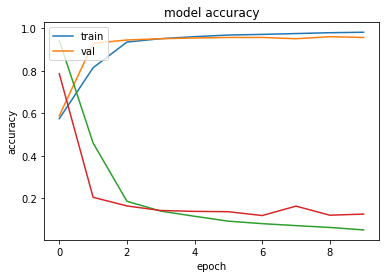

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate_generator(train_dataset, steps=9)
validation_loss, test_acc = model.evaluate_generator(val_dataset, steps=9)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Train: 0.990, Test: 0.958


In [ ]:
model.save('Auto VGG16 Maize-Crop-Disease.h5')